# Working with TESS time series data

### First, what is TESS?

TESS is the "Transiting Exoplanet Survey Satellite". It is a space telescope run by NASA that observes the entire sky in 26 batches over the course of two years, with the goal of finding Earth-like exoplanets. While it's identified several thousand exoplanet candidates, because it observes the entire sky, data exists for any sufficiently bright star. Some key characteristics:
- The pixels are 21 arcseconds wide
- Only stars brighter than ~12th mag are detectable
- Most stars have a 30-minute observation cadence (a small subset have a 2-minute cadence)


### What are the goals for today?

1. Learn how to download and work with TESS data
2. Apply a Lomb-Scargle periodogram to read photometric data
3. Phase-fold time-series data to determine a lightcurve
4. Produce a preliminary color-rotation period diagram


### As always, let's start by loading up the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import lightkurve as lk

%matplotlib inline

### Let's start by working with a known variable - RR Lyra

We'll first check for what data is available, and grab: 1) full-frame images, 2) the TESS pixel files, and 3) search for any pre-generated lightcurves. The package `lightkurve` makes this process trivial. 

Notice that we specify that we are looking for TESS data in the search for pixel files and pre-computed lightcurves. `lightkurve` allows us to perform search for Kepler and K2 data as well, but we'll focus on TESS data here.

In [2]:
star = 'RR Lyra'

# Search for what full-frame image data is available
search_ffi = lk.search_tesscut(star)

# search for the pixel file
search_tpf = lk.search_targetpixelfile(star, mission='TESS')

# Search for available pre-computed lightcurves
search_lcf = lk.search_lightcurve(star, mission='TESS')

### Let's see what full-frame images are available...

In [3]:
search_ffi

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,TESScut,1426,RR Lyra,0.0
1,TESS Sector 15,2019,TESScut,1426,RR Lyra,0.0
2,TESS Sector 40,2021,TESScut,475,RR Lyra,0.0
3,TESS Sector 41,2021,TESScut,475,RR Lyra,0.0
4,TESS Sector 54,2022,TESScut,475,RR Lyra,0.0
5,TESS Sector 55,2022,TESScut,475,RR Lyra,0.0


### ...so it looks like TESS has observed RR Lyra 6 times

How is this possible? First, remember that TESS observes the entire sky in 2 years. But TESS launched in 2018, and it's still orbiting the Earth, producing data. Since it's launch, TESS has observed the entire sky three separate times. Then why are there six observations of RR Lyra and not three? The TESS observing strategy has it staring at one part of the sky for 30 days, then shifting over and staring at the next patch for 30 days. Certain parts of the sky overlap with each other, so stars may be observed on successive 30-day periods.

Looking above, we see that RR Lyra was observed in Sectors 14 and 15 in 2019, then again in Sectors 40 and 41 in 2021, and finally as part of Sectors 54 and 55 in 2022. The exposure times show that the first observations had a 1426-second (30-minute) cadence while the 2021 and 2022 observations had a 475-second (8-minute) cadence.

### Now, let's look at the available pixel files

In [4]:
search_tpf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,159717514,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,159717514,0.0
2,TESS Sector 40,2021,SPOC,120,159717514,0.0
3,TESS Sector 40,2021,TESS-SPOC,600,159717514,0.0
4,TESS Sector 41,2021,SPOC,120,159717514,0.0
5,TESS Sector 41,2021,TESS-SPOC,600,159717514,0.0


### So pixel files have only been generated for Sectors 14, 40, and 41 so far. What about pre-computed lightcurves?



In [5]:
search_lcf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,159717514,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,159717514,0.0
2,TESS Sector 40,2021,SPOC,120,159717514,0.0
3,TESS Sector 40,2021,TESS-SPOC,600,159717514,0.0
4,TESS Sector 41,2021,SPOC,120,159717514,0.0
5,TESS Sector 41,2021,TESS-SPOC,600,159717514,0.0


### Let's grab one of these lightcurves...

In [6]:
search_lcf_refined = lk.search_lightcurve(star, author="SPOC", exptime=120)
search_lcf_refined 

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,159717514,0.0
1,TESS Sector 40,2021,SPOC,120,159717514,0.0
2,TESS Sector 41,2021,SPOC,120,159717514,0.0


### ...and download them

In [7]:
lcf = search_lcf_refined.download_all()
lcf

LightCurveCollection of 3 objects:
    0: <TessLightCurve LABEL="TIC 159717514" SECTOR=14 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 159717514" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 159717514" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

### Let's look at one of those light curves

In [8]:
lcf[0]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1683.3564705189142,-1.8327723e+04,5.2114471e+01,2.5505386e-03,328247,2044.55056,470.53095,8.8994242e+04,3.1956331e+01,1.0076165e+03,2.4983354e+00,-1.8327723e+04,5.2114471e+01,0,nan,nan,nan,nan,2044.55056,1.7824541e-04,470.53095,1.7884959e-04,-2.0288628e-02,-4.5269866e-02
1683.3578594148944,-1.8292363e+04,5.2083363e+01,2.5505463e-03,328248,2044.55269,470.53132,8.8922383e+04,3.1937258e+01,1.0096708e+03,2.4953408e+00,-1.8292363e+04,5.2083363e+01,0,nan,nan,nan,nan,2044.55269,1.7821211e-04,470.53132,1.7887913e-04,-1.8252680e-02,-4.5662105e-02
1683.3592483106422,-1.8275150e+04,5.2061539e+01,2.5505538e-03,328249,2044.55054,470.53017,8.8844438e+04,3.1923874e+01,1.0104371e+03,2.4975593e+00,-1.8275150e+04,5.2061539e+01,0,nan,nan,nan,nan,2044.55054,1.7837030e-04,470.53017,1.7898367e-04,-2.1315737e-02,-4.7097884e-02
1683.360637206622,-1.8207182e+04,5.2048630e+01,2.5505614e-03,328250,2044.54995,470.52884,8.8808672e+04,3.1915956e+01,1.0090530e+03,2.4948943e+00,-1.8207182e+04,5.2048630e+01,0,nan,nan,nan,nan,2044.54995,1.7842038e-04,470.52884,1.7903637e-04,-2.3226870e-02,-4.9998857e-02
1683.3620261023686,-1.8360795e+04,5.1998409e+01,2.5505689e-03,328251,2044.55015,470.53327,8.8623000e+04,3.1885160e+01,1.0093122e+03,2.4950247e+00,-1.8360795e+04,5.1998409e+01,0,nan,nan,nan,nan,2044.55015,1.7861344e-04,470.53327,1.7915065e-04,-2.3022927e-02,-4.1238856e-02
1683.363414998349,-1.8106779e+04,5.2008068e+01,2.5505766e-03,328252,2044.55050,470.53304,8.8668164e+04,3.1891085e+01,1.0053417e+03,2.4923151e+00,-1.8106779e+04,5.2008068e+01,0,nan,nan,nan,nan,2044.55050,1.7854487e-04,470.53304,1.7909825e-04,-2.0471605e-02,-4.1657086e-02
1683.3648038940964,-1.8316537e+04,5.1953426e+01,2.5505840e-03,328253,2044.54959,470.52946,8.8466633e+04,3.1857580e+01,1.0104185e+03,2.4958167e+00,-1.8316537e+04,5.1953426e+01,0,nan,nan,nan,nan,2044.54959,1.7879184e-04,470.52946,1.7938559e-04,-2.3175942e-02,-4.8902791e-02
1683.366192790077,-1.7731258e+04,5.2033623e+01,2.5505917e-03,328254,2044.54916,470.53185,8.8751375e+04,3.1906752e+01,1.0068947e+03,2.4964802e+00,-1.7731258e+04,5.2033623e+01,0,nan,nan,nan,nan,2044.54916,1.7850567e-04,470.53185,1.7904038e-04,-2.3263166e-02,-4.4307705e-02


### Now, let's plot that data!

We are going to plot the `pdcsap_flux` instead of the `flux` or the `sap_flux` because long-term trends have been removed in the `pdcsap_flux` lightcurve. Note that SAP stands for simple-aperture photometry while PDCSAP stands for pre-search data conditioning simple-aperture photometry.

/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1037: LightkurveWarning: The light curve appears to be zero-centered (median=1.39e+04 electron / s +/- 3.05e+04 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,


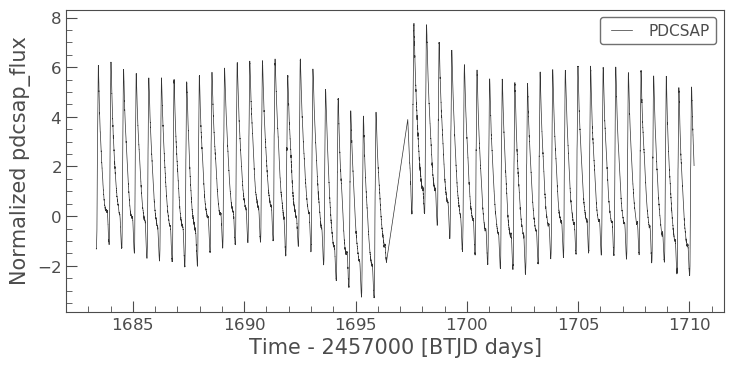

In [9]:
lcf[0].plot(column='pdcsap_flux', normalize=True, label="PDCSAP");

Notice that these lightcurves are not perfect - there appears to be some variability. This is caused by scattered light and other noise issues. For more information refer to [these tutorials](https://docs.lightkurve.org/tutorials/index.html#removing-instrumental-noise). For now, let's think about how we can manipulate the light curves. There are a set of useful functions in `lightkurve` which you can use to work with the data. 
These include:

- [flatten()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.flatten.html?highlight=flatten#lightkurve.LightCurve.flatten): Remove long term trends using a Savitzky–Golay filter
- [remove_outliers()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.remove_outliers.html?highlight=remove_outliers): Remove outliers using simple sigma clipping
- [remove_nans()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.remove_nans.html?highlight=remove_nans): Remove infinite or NaN values (these can occur during thruster firings)
- [fold()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.fold.html?highlight=fold): Fold the data at a particular period
- [bin()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.bin.html?highlight=bin): Reduce the time resolution of the array, taking the average value in each bin.

We can use these simply on a light curve object.

### Let's run a Lomb-Scargle Periodogram RR Lyra now

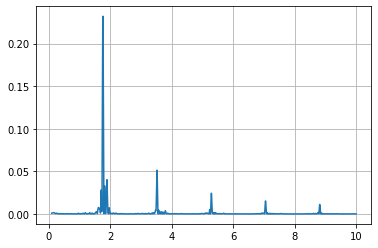

In [15]:
from scipy.signal import lombscargle

freq_max = 10
N_freq_test = 10000

# do not change these...
frequencies = np.linspace(0.1, freq_max, N_freq_test)
angular_frequencies = 2 * np.pi * frequencies

times = lcf[0]['time'].value
fluxes = lcf[0]['pdcsap_flux'].value

idx = np.where(fluxes > 0)[0]
times = times[idx]
fluxes = fluxes[idx]


# create the periodograms
# We are using the same data from above
periodogram = lombscargle(times, fluxes, angular_frequencies, normalize=True, precenter=True)

# Plot the periodogram
plt.plot(frequencies, periodogram, color="C0", label='Periodogram')

plt.grid()

plt.show()

### We'll use a quick script to find a few of the peak frequencies

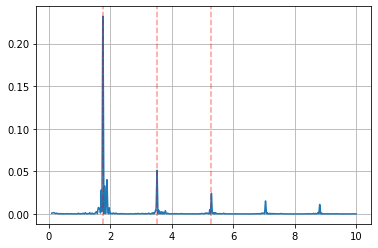

In [16]:
def find_peak(freq, power, f_min, f_max):

    idx = np.intersect1d(np.where(freq > f_min)[0],
                         np.where(freq < f_max)[0])
    idx2 = np.argmax(power[idx])
    
    return freq[idx][idx2]
    
# Find the peak frequencies
f0 = find_peak(frequencies, periodogram, 1.7, 2.1)
f1 = find_peak(frequencies, periodogram, 3, 4)
f2 = find_peak(frequencies, periodogram, 5, 5.5)


# Plot the periodogram
plt.plot(frequencies, periodogram, color="C0", label='Periodogram')

for f in [f0, f1, f2]:
    plt.axvline(f, color='r', alpha=0.4, linestyle='dashed')

plt.grid()

plt.show()

### Now, let's phase-fold the lightcurves over the top three frequencies

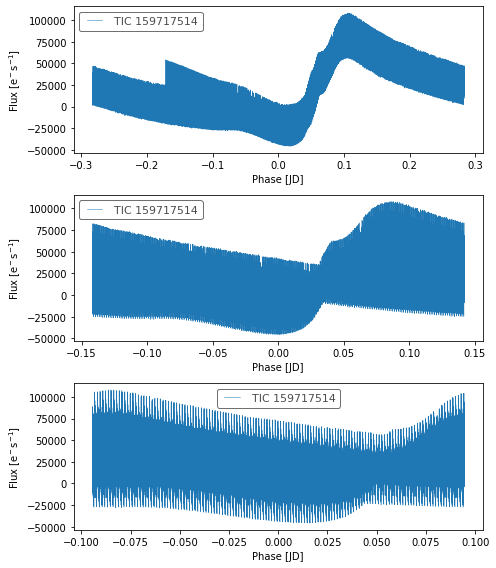

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(7,8))

folded_lc0 = lcf[0].fold(period=1/f0)
folded_lc0.plot(ax=ax[0])

folded_lc1 = lcf[0].fold(period=1/f1)
folded_lc1.plot(ax=ax[1])

folded_lc2 = lcf[0].fold(period=1/f2)
folded_lc2.plot(ax=ax[2])

plt.tight_layout()
plt.show()

### That's kind of ugly. What can we do about it? Bin the data!

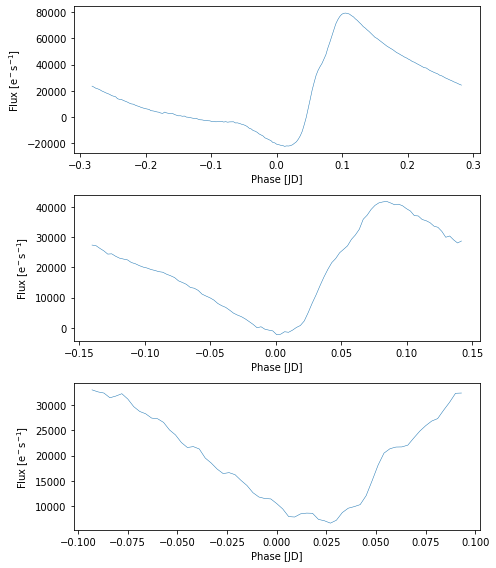

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(7,8))

binned_lc0 = folded_lc0.bin(time_bin_size=0.003)
binned_lc0.plot(ax=ax[0])

binned_lc1 = folded_lc1.bin(time_bin_size=0.003)
binned_lc1.plot(ax=ax[1])

binned_lc2 = folded_lc2.bin(time_bin_size=0.003)
binned_lc2.plot(ax=ax[2])

plt.tight_layout()
plt.show()

The top plot - the one representing the strongest frequency - shows a clear signal. Comparison with library templates shows that this lightcurve corresponds to an RR Lyra-type lightcurve. Of course, this is no surprise. We are looking at the prototype, RR Lyra, itself.


### Now what if we don't have a pre-computed lightcurve? We're going to have to make our own

Returning back to the list of full-frame images, we have 6 images, the latest one from Sector 55 that lacks a pixel file and corresponding pre-computed lightcurve. Let's make a lightcurve for that sector. We'll start by plotting the full-frame image from that sector. 

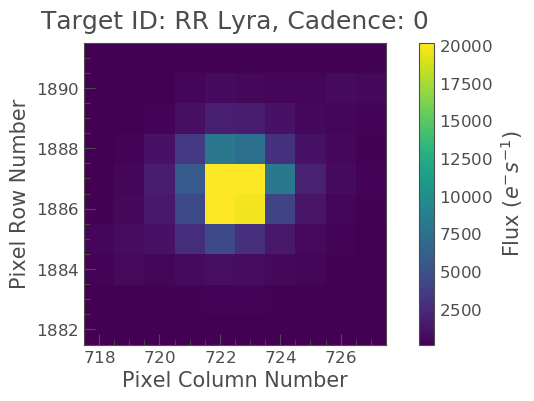

In [19]:
ffi_data = search_ffi[5].download(cutout_size=10)

ffi_data.plot()

plt.show()

### Now, let's make a pixel mask. We'll set a threshold value of 10

Why are we chosing 10 as our threshold? There isn't one signel value that is the correct one for all stars. This value works for RR Lyra, but will not necessarily work for every star. You want to pick your threshold value based on how bright your star is and if other stars have any overlapping PSFs.

We are including 11 pixels


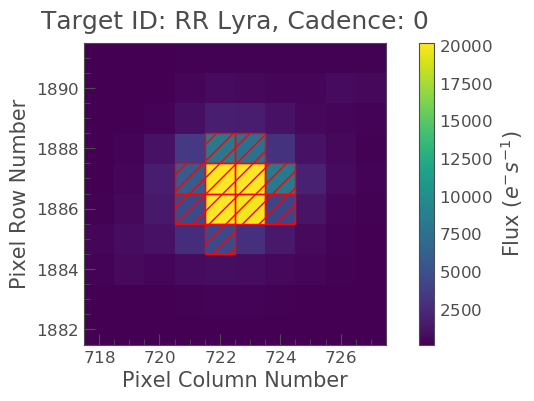

In [20]:
target_mask = ffi_data.create_threshold_mask(threshold=10, reference_pixel='center')
n_target_pixels = target_mask.sum()
print("We are including", n_target_pixels, "pixels")

ffi_data.plot(aperture_mask=target_mask, mask_color='r')

plt.show()

### Now that we have our pixel mask defined, we can create a lightcurve

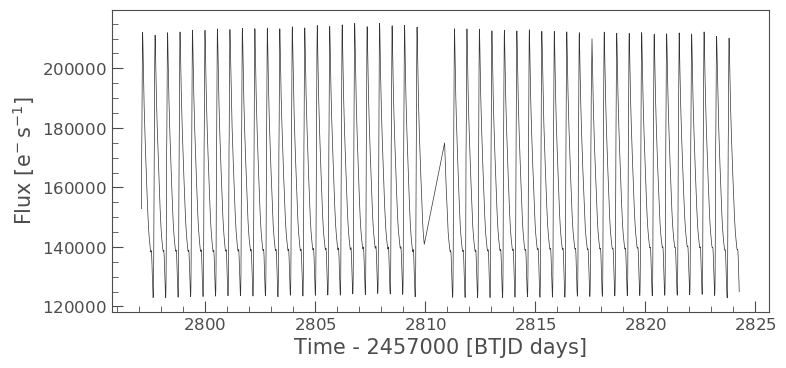

In [21]:
ffi_lc = ffi_data.to_lightcurve(aperture_mask=target_mask)

ffi_lc.plot()

plt.show()

### Now, let's re-calculate the Lomb-Scargle periodogram and phase-fold the result

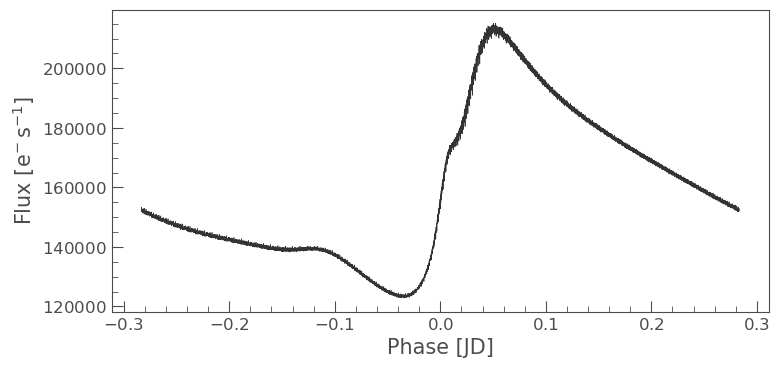

In [22]:
# Let's re-calculate
times = ffi_lc['time'].value
fluxes = ffi_lc['flux'].value

idx = np.where(fluxes > 0)[0]
times = times[idx]
fluxes = fluxes[idx]

periodogram = lombscargle(times, fluxes, angular_frequencies, normalize=True, precenter=True)

# Find the best frequency
f0 = find_peak(frequencies, periodogram, 1.7, 2.1)


folded_lc0 = ffi_lc.fold(period=1/f0)
folded_lc0.plot()

plt.show()

### Now, that's a good lightcurve!!

## Exoplanet Example: What if we choose a more subtle variable? 

In [23]:
star = 'L 98-59'

# Search for what full-frame image data is available
search_ffi = lk.search_tesscut(star)
search_ffi

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TESScut,1426,L 98-59,0.0
1,TESS Sector 02,2018,TESScut,1426,L 98-59,0.0
2,TESS Sector 05,2018,TESScut,1426,L 98-59,0.0
3,TESS Sector 08,2019,TESScut,1426,L 98-59,0.0
4,TESS Sector 09,2019,TESScut,1426,L 98-59,0.0
5,TESS Sector 10,2019,TESScut,1426,L 98-59,0.0
6,TESS Sector 11,2019,TESScut,1426,L 98-59,0.0
7,TESS Sector 12,2019,TESScut,1426,L 98-59,0.0
8,TESS Sector 28,2020,TESScut,475,L 98-59,0.0


We are including 10 pixels


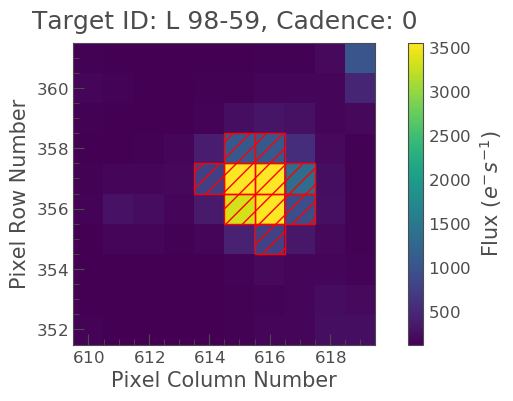

In [24]:
ffi_data = search_ffi[18].download(cutout_size=10)

target_mask = ffi_data.create_threshold_mask(threshold=10, reference_pixel='center')
n_target_pixels = target_mask.sum()
print("We are including", n_target_pixels, "pixels")

ffi_data.plot(aperture_mask=target_mask, mask_color='r')


plt.show()

### Now, let's plot the lightcurve

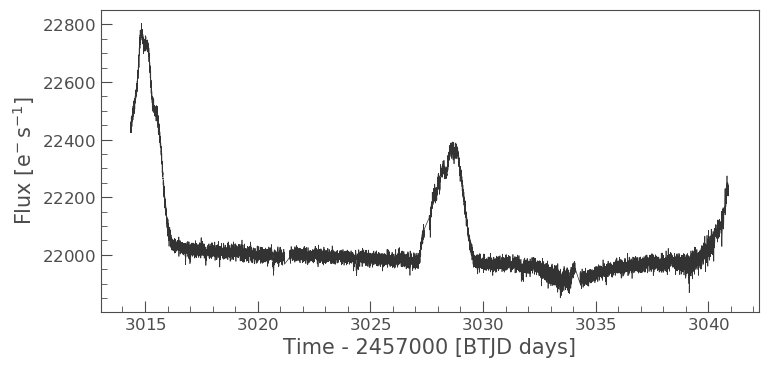

In [25]:
ffi_lc = ffi_data.to_lightcurve(aperture_mask=target_mask)
ffi_lc.plot()

plt.show()

### That's a little strange. What's going on here? Let's look at the lightcurve of the non-star pixels

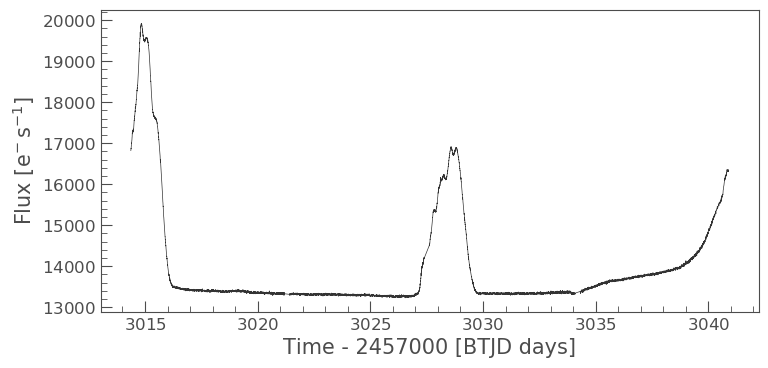

In [26]:
ffi_lc = ffi_data.to_lightcurve(aperture_mask=~target_mask)
ffi_lc.plot()

plt.show()

### Strange! It looks like the lightcurve of our star is very similar to the lightcurve of all the non-star pixels.

Why is this happening? It turns out that there are a number of other issues that affect the lightcurves, most notably stray light. TESS has a ~14 day orbit, and it looks like the light curve above has a ~14-day period. Likely what happens is that light reflects off parts of the telescope at a particular part of the orbit, causing an increased background. 

### Let's remove this background light!

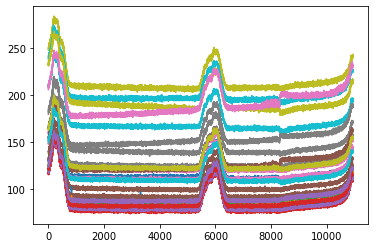

In [27]:
regressors = ffi_data.flux[:, ~target_mask]

plt.plot(regressors[:, :30]);

In [28]:
from lightkurve.correctors import DesignMatrix
dm = DesignMatrix(regressors, name='regressors')
dm = dm.append_constant()

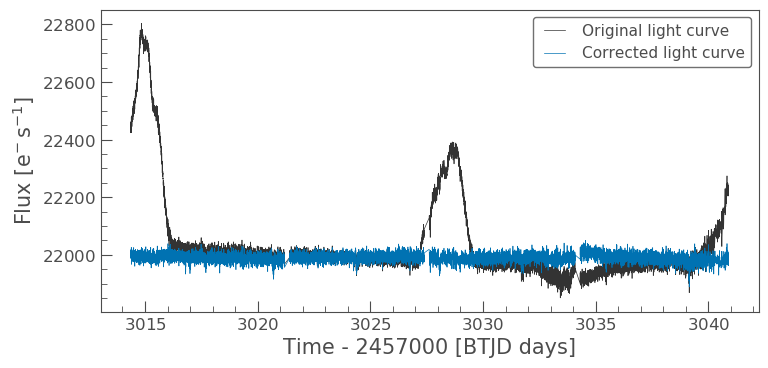

In [29]:

from lightkurve.correctors import RegressionCorrector


uncorrected_lc = ffi_data.to_lightcurve(aperture_mask=target_mask)

corrector = RegressionCorrector(uncorrected_lc)

corrected_lc = corrector.correct(dm)

ax = uncorrected_lc.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

### Now that we have a corrected lightcurve, what do we see?

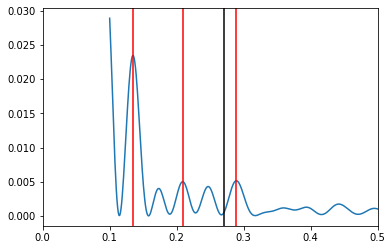

In [30]:
freq_max = 10
N_freq_test = 10000

# do not change these...
frequencies = np.linspace(0.1, freq_max, N_freq_test)
angular_frequencies = 2 * np.pi * frequencies

times = corrected_lc['time'].value
fluxes = corrected_lc['flux'].value



# create the periodograms
# We are using the same data from above
periodogram = lombscargle(times, fluxes, angular_frequencies, normalize=True)


p0 = 1/find_peak(frequencies, periodogram, 0.11, 0.15)
p1 = 1/find_peak(frequencies, periodogram, 0.2, 0.25)
p2 = 1/find_peak(frequencies, periodogram, 0.25, 0.3)



# Plot the periodogram
plt.plot(frequencies, periodogram, color="C0", label='Periodogram')


plt.axvline(1/p0, color='r')
plt.axvline(1/p1, color='r')
plt.axvline(1/p2, color='r')

plt.axvline(1/3.690621, color='k')

plt.xlim(0, 0.5)

plt.show()

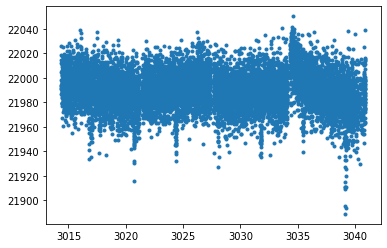

In [31]:
times = corrected_lc['time'].value
fluxes = corrected_lc['flux'].value

plt.scatter(times, fluxes, marker='.')

plt.show()

### Hmm, this is interesting. This comb structure could be due to eclipses. Let's zoom in for a closer look

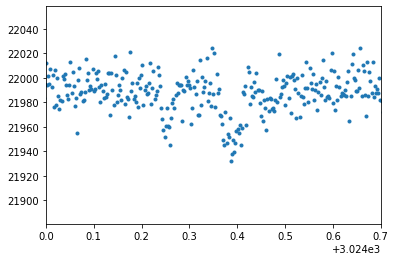

In [32]:
times = corrected_lc['time'].value
fluxes = corrected_lc['flux'].value

plt.scatter(times, fluxes, marker='.')

plt.xlim(3024, 3024.7)

plt.show()

### That's looking a lot like an eclipse. Or maybe two eclipses...

It turns out this is a known exoplanet-host. In fact according to [this paper](https://arxiv.org/pdf/1903.08017.pdf), L 98-59 actually has three planets, with orbital periods of 2.25 days, 3.69 days, and 7.45 days. Let's phase-fold on these periods to see if we can find the transits.

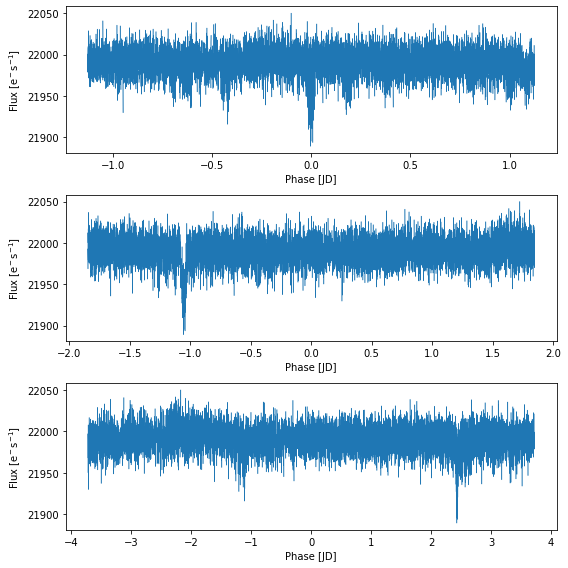

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8))

folded_lc_b = corrected_lc.fold(period=2.2531136)
folded_lc_b.plot(ax=ax[0])

folded_lc_c = corrected_lc.fold(period=3.690621)
folded_lc_c.plot(ax=ax[1])

folded_lc_d = corrected_lc.fold(period=7.4507245)
folded_lc_d.plot(ax=ax[2])


plt.tight_layout()
plt.show()

### Looks like we have some transits. Let's zoom in on them

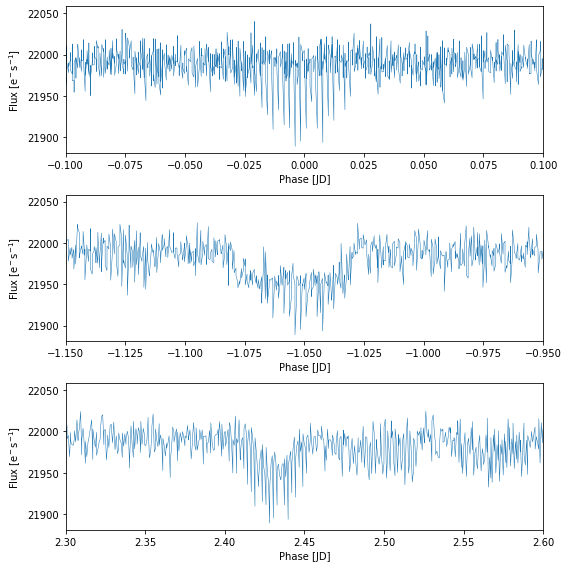

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8))

folded_lc_b = corrected_lc.fold(period=2.2531136)
folded_lc_b.plot(ax=ax[0])
ax[0].set_xlim(-0.1, 0.1)

folded_lc_c = corrected_lc.fold(period=3.690621)
folded_lc_c.plot(ax=ax[1])
ax[1].set_xlim(-1.15, -0.95)

folded_lc_d = corrected_lc.fold(period=7.4507245)
folded_lc_d.plot(ax=ax[2])
ax[2].set_xlim(2.3, 2.6)


plt.tight_layout()
plt.show()

These different structures are occurring because there are three different planets, and with such short periods, sometimes multiple planets are eclipsing at the same time.

# Creating a color-period diagram for Pleiades

In [35]:
from astropy import units as u
from astropy.coordinates import SkyCoord

pleiades = np.load("data/pleiades.npy")
pleiades = pleiades[pleiades['phot_g_mean_mag'] < 15]

c = SkyCoord(ra=pleiades['ra']*u.degree, dec=pleiades['dec']*u.degree, frame='icrs')

### We'll start with the zero-eth star for an example

In [36]:
idx = 0
search_ffi = lk.search_tesscut(c[idx])

search_ffi

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 42,2021,TESScut,475,"56.82547250246683, 24.03644264435525",0.0
1,TESS Sector 43,2021,TESScut,475,"56.82547250246683, 24.03644264435525",0.0
2,TESS Sector 44,2021,TESScut,475,"56.82547250246683, 24.03644264435525",0.0


We are including 4 pixels


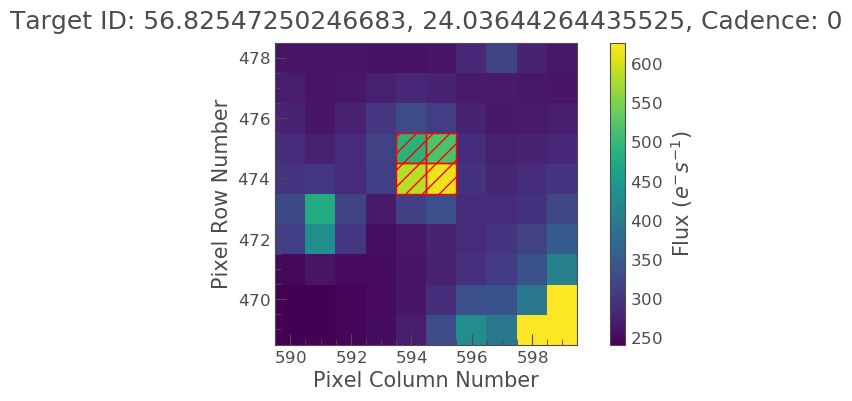

In [37]:
ffi_data = search_ffi[0].download(cutout_size=10)

target_mask = ffi_data.create_threshold_mask(threshold=5, reference_pixel='center')
n_target_pixels = target_mask.sum()
print("We are including", n_target_pixels, "pixels")

ffi_data.plot(aperture_mask=target_mask, mask_color='r')

plt.show()

### Uh oh. There is a bright star in the corner of the aperture

If we don't do something about that, variability in that star will affect our background subtraction. We could remove it by hand when we set the background pixel map, or alternatively, we could use download a data set with a smaller cutout size.

We are including 4 pixels


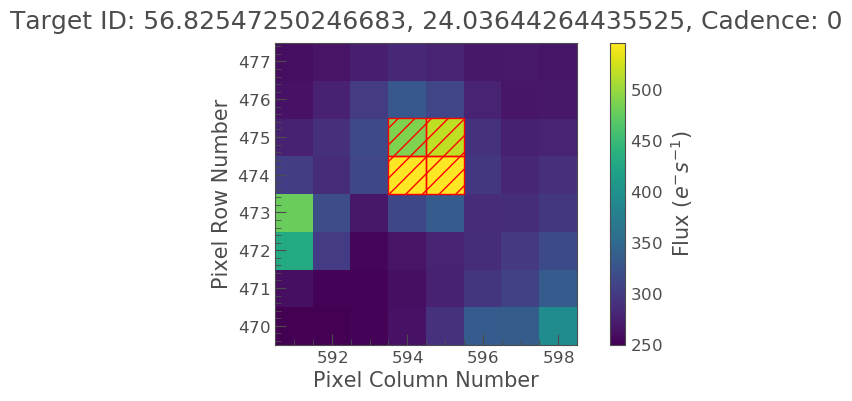

In [38]:
ffi_data = search_ffi[0].download(cutout_size=8)

target_mask = ffi_data.create_threshold_mask(threshold=5, reference_pixel='center')
n_target_pixels = target_mask.sum()
print("We are including", n_target_pixels, "pixels")

ffi_data.plot(aperture_mask=target_mask, mask_color='r')

plt.show()

### Let's find the background light and remove it's effect on the star's lightcurve

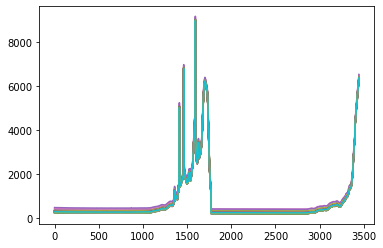

In [39]:
regressors = ffi_data.flux[:, ~target_mask]

plt.plot(regressors[:, :40]);

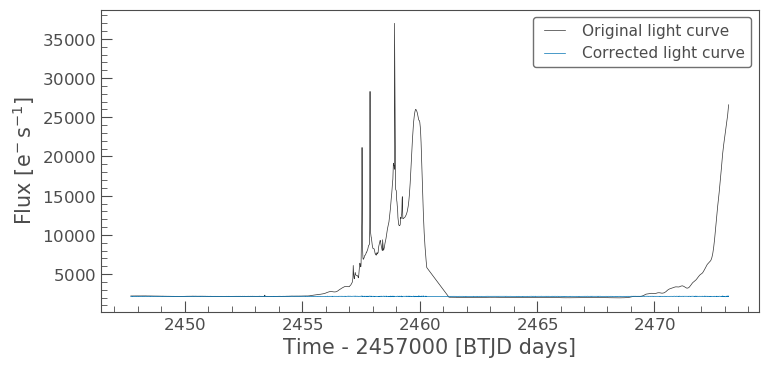

In [40]:
dm = DesignMatrix(regressors, name='regressors')
dm = dm.append_constant()

uncorrected_lc = ffi_data.to_lightcurve(aperture_mask=target_mask)

corrector = RegressionCorrector(uncorrected_lc)

corrected_lc = corrector.correct(dm)

ax = uncorrected_lc.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

### Now, let's plot the lightcurve

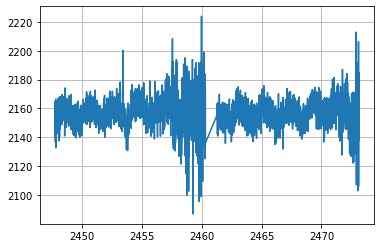

In [41]:
plt.plot(corrected_lc['time'].value, corrected_lc['flux'].value)

plt.grid()

plt.show()

### There's some pretty clear variability. Let's make a Lomb-Scargle periodogram

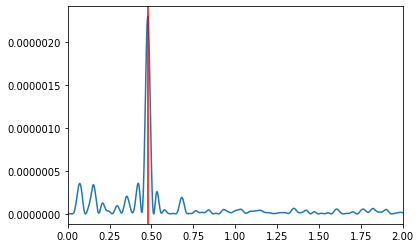

In [42]:
freq_max = 10
N_freq_test = 10000

# do not change these...
frequencies = np.linspace(0.01, freq_max, N_freq_test)
angular_frequencies = 2 * np.pi * frequencies

times = corrected_lc['time'].value
fluxes = corrected_lc['flux'].value



# create the periodograms
# We are using the same data from above
periodogram = lombscargle(times, fluxes, angular_frequencies, precenter=True, normalize=True)

p0 = 1/find_peak(frequencies, periodogram, 0.11, 1)

# Plot the periodogram
plt.plot(frequencies, periodogram, color="C0", label='Periodogram')


plt.axvline(1/p0, color='r')

plt.xlim(0, 2)
# plt.ylim(0, 3e-6)


plt.show()

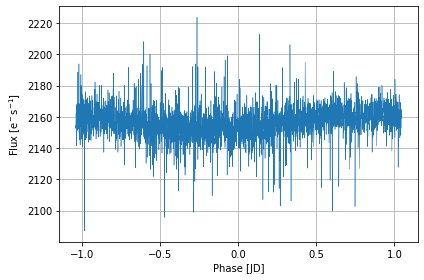

In [43]:
fig = plt.figure()

ax = plt.gca()

folded_lc_b = corrected_lc.fold(period=p0)
folded_lc_b.plot(ax=ax)

plt.grid()

# plt.ylim(2120, 2180)

plt.tight_layout()
plt.show()

### It's a bit difficult to make out clearly, but there is a variation